# Vatiational Quantum Thermalizer tutorial

In this demo, we discuss the Variational Quantum Thermalizer (VQT), which can be used for generating the thermal state of a given Hamiltonian and target temperature, a task for which Quantum Hamiltonian Based Models are well-suited. The VQT can be seen as a generalization of the Variational Quantum Eigensolver (VQE) to thermal states: we show that the VQT converges to the VQE in the zero temperature limit.

## Initial setup

Before we truly get started, we will define the required software packages and initalizes some variables.

### Define the required packages
We will make use of cirq, tensorflow, tensorflow quantum, as well as the qhbm library. They are all installed when you pip install qhbmlib. 

In [1]:
!pip install -q qhbmlib==0.2.1

import cirq
import sympy
import tensorflow as tf
import tensorflow_quantum as tfq

from qhbmlib import ebm
from qhbmlib import qhbm
from qhbmlib import qnn
from qhbmlib import vqt

     |████████████████████████████████| 4.8 MB 10.2 MB/s 
     |████████████████████████████████| 394.3 MB 11 kB/s 
     |████████████████████████████████| 7.8 MB 15.4 MB/s 
     |████████████████████████████████| 3.8 MB 41.8 MB/s 
     |████████████████████████████████| 462 kB 48.1 MB/s 
     |████████████████████████████████| 2.9 MB 47.3 MB/s 
     |████████████████████████████████| 90 kB 7.7 MB/s 
     |████████████████████████████████| 1.3 MB 45.3 MB/s 
     |████████████████████████████████| 5.6 MB 31.8 MB/s 
     |████████████████████████████████| 100 kB 8.2 MB/s 
     |████████████████████████████████| 90 kB 6.2 MB/s 
     |████████████████████████████████| 380 kB 57.6 MB/s 
     |████████████████████████████████| 1.5 MB 65.6 MB/s 
     |████████████████████████████████| 93 kB 974 kB/s 
     |████████████████████████████████| 93 kB 1.3 MB/s 
     |████████████████████████████████| 93 kB 997 kB/s 
     |████████████████████████████████| 93 kB 1.1 MB/s 
     |█████████████████████

### Initial variabels
In this section we set basic info on our setup, such as the number of qubits used. In our example, we will stick with a single-qubit setup. If one were to extend our example to a multi-qubit setup, the resulting system would be a tensor-product of one-qubit systems. However, it should be noted that for the general case, the Quantum Hamiltonian Model can model any density matrix. 

In [2]:
num_qubits = 1 # the size of the system we will use
seed = ord("*") # our seed, naturally being the answer to life, the universe, and everything. What else?

## Quantum Hamiltonian Based Model

We will model the evolution by making use of the Quantum Hamiltonian Based Model. Here, we sample bitstrings from a classical probability distribution $p$ parameterized by $\theta$, which are used to initalize a quantum state $\rho(\theta)$ referred to as the latent state. The parameterized unitary $U(\phi)$ acts upon this $\rho(\theta)$ to create the visible state. A schematic is shown in the figure below below, followed by an deep dive into both states. 

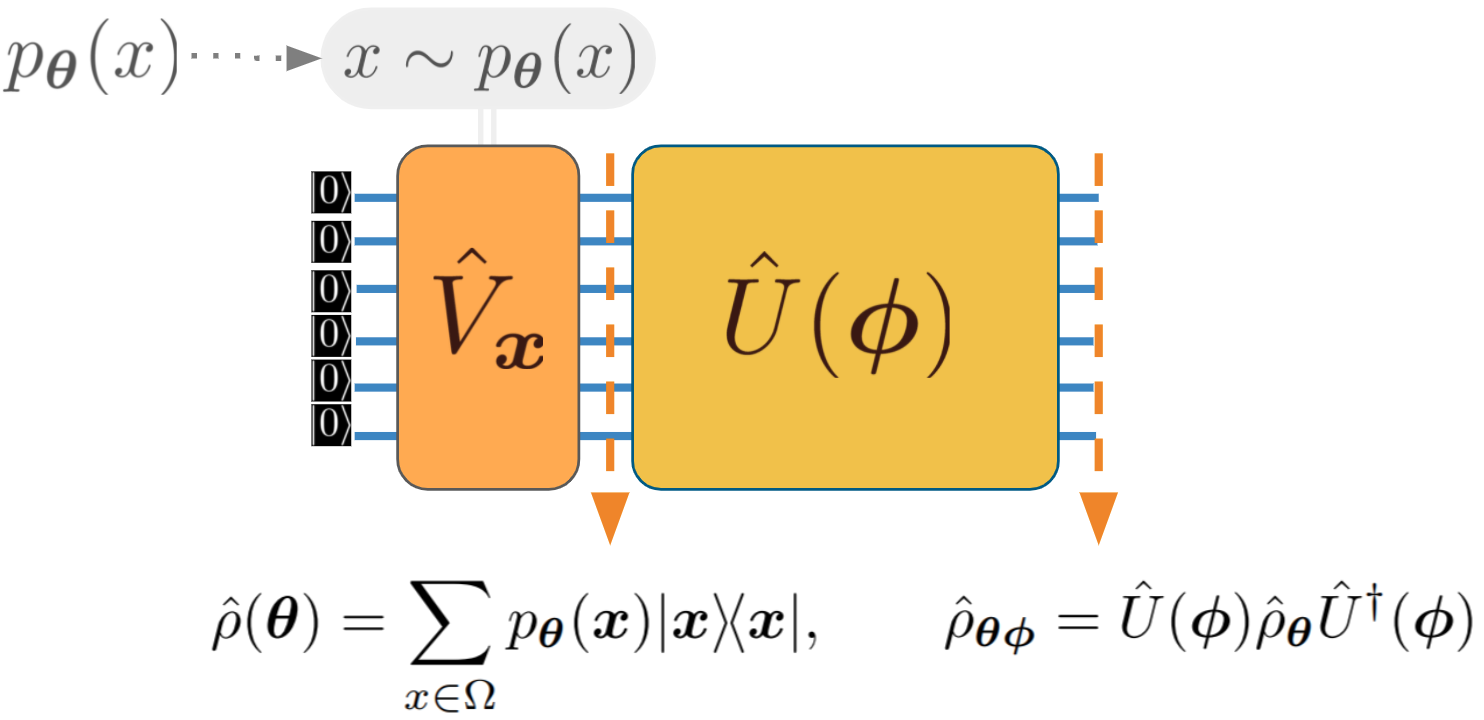

### The latent state

The latent state is defined by the sum of the eigenvalues of some density operator

$$\rho_\theta \equiv \sum_x p_\theta(x) |x\rangle\langle x|$$

For the right choice of $p_\theta$, this can represent the eigenvalues of any density matrix. It is important to note that we can write this as the exponential of some operator $K$, as this is convenient for taking derivatives and defining loss functions that involve logarithms.

\begin{align}
  \rho_\theta &= \sum_{x \in \Omega} \left( \frac{e^{-E_\theta(x)}}{Z_\theta} \right) |x\rangle\langle x| \\
  &= Z_\theta^{-1} e^{-\sum_{x \in \Omega} E_\theta(x) |x\rangle\langle x|} \\
  &= \frac{e^{-K_\theta}}{Z_\theta}
\end{align}

where the partition function $Z_\theta$ is given by
$$Z_\theta= \mathrm{Tr}[e^{-K_\theta}]$$

For our example, we will make use of a variation of the Bernoulli distribution. The general Bernoulli distribution is given as
$$p_\alpha(x) = \alpha^x (1-\alpha)^{1-x}$$
We re-parameterize the Bernoulli distribution with 
$$\theta = \frac{1}{2}\log \left( \frac{\alpha}{1-\alpha}\right), $$
which corresponds to the energy of a spin $\frac{1}{2}$ particle:  
$$ E_\theta(x) =     
  \begin{cases}
      \theta, & \text{if}\ x=0 \\
      -\theta, & \text{if}\ x=1.
  \end{cases} 
$$

The latent modular Hamiltonian corresponding to a Bernoulli is then given by
\begin{align}
K_\theta &= 
\sum_x E_\theta(x) |x\rangle\langle x| \\
&= E_\theta(0) |0\rangle\langle 0| + E_\theta(1) |1\rangle\langle 1| \\
&= \begin{bmatrix} \theta & 0 \\ 0 & -\theta \end{bmatrix}
\end{align}

Using our definition, this yields the following latent state
\begin{align}
\rho_\theta &= \frac{e^{-K_\theta}}{Z_\theta} = \frac{1}{e^{-\theta} + e^{\theta}}\begin{bmatrix}
    e^{-\theta} & 0 \\
    0 & e^{\theta}
\end{bmatrix}.
\end{align}

An alternative method to derive this is given in appendix "A. Bernoulli distribution".

In code, this can be implemented using the ebm.Bernoulli function: 

In [3]:
vqt_func = vqt.vqt # define our vqt function

# define the EBM
ebm_init = tf.keras.initializers.RandomUniform(
    minval=-2.0, maxval=2.0, seed=seed) # use samples from the uniform distribution to initialize the Bernoulli distribution
test_ebm = ebm.Bernoulli(num_qubits, ebm_init, True) # We will use the Bernoulli distribution to initialize the EBM

### The visible state

To complete the model, we use $U(\phi)$ to add the quantum correlations. The evolution of a density matrix under the action of a unitary is written as

$$ \rho_{\theta\phi} = \hat{U}(\phi) \rho_{\theta} \hat{U}^\dagger(\phi). $$

By taking the log, we can work our way back to the modular Hamiltonian

\begin{align}
  \log(\rho_{\theta\phi}) &= \frac{e^{-K_{\theta\phi}}}{Z_{\theta\phi}} \\
  &= \log(e^{-K_{\theta\phi}}) + \log(Z_{\theta\phi}^{-1}) \\
  &= -K_{\theta\phi} - \log(Z_{\theta\phi}).
\end{align}
As 
\begin{align}
 Z_{\theta\phi} &= \mathrm{Tr[e^{-K_{\theta\phi}} ]} \\
 &= \mathrm{Tr[U(\phi) e^{-K_\theta} U^\dagger(\phi) )]} \\ 
 &= \mathrm{Tr[U^\dagger(\phi) U(\phi) e^{-K_\theta})]} \\
 &= \mathrm{Tr[e^{-K_\theta})]} \\
 &= Z_{\theta}
 \end{align}
we get
$$K_{\theta\phi} = -\log \left(\rho_{\theta\phi}\right)-\log(Z_\theta)$$

For our example, we will make use of an ansatz that consists solely of a single $R_X$ gate parameterized by $\phi$. This allows our ansatz to be written as
$$
\hat{U}(\phi) = R_x(\phi) = e^{-i\frac{\phi}{2}X} = \begin{bmatrix}\cos\frac{\phi}{2} & -i\sin\frac{\phi}{2}\\-i\sin\frac{\phi}{2} & \cos\frac{\phi}{2}\end{bmatrix}.
$$
In code, the circuit $U(\phi)$ is implemented as follows

In [4]:
# define the QNN
qubits = cirq.GridQubit.rect(1, num_qubits) # In our example, we only use a single qubit. Larger systems with our example would be initialized in a line
r_symbols = [sympy.Symbol(f"phi_{n}") for n in range(num_qubits)] # the placeholder variable
r_circuit = cirq.Circuit(
    cirq.rx(r_s)(q) for r_s, q in zip(r_symbols, qubits)) # a single rotational pauli X for the QNN
qnn_init = tf.keras.initializers.RandomUniform(
    minval=-6.2, maxval=6.2, seed=seed) # init with values sampled from the uniform distribution
test_qnn = qnn.QNN(r_circuit, initializer=qnn_init, is_analytic=True) # initialize the actual QNN

Looking back at the definition of the full model visible state, we get for our example 
\begin{align}
 \rho_{\theta\phi} &= \hat{U}(\phi) \rho_{\theta} \hat{U}^\dagger(\phi) \\
  &= \frac{1}{e^{-\theta} + e^{\theta}} R_x(\phi) \begin{bmatrix}
    e^{-\theta} & 0 \\
    0 & e^{\theta}
  \end{bmatrix} R_x^\dagger(\phi) \\
  &= \frac{1}{e^{-\theta} + e^{\theta}}
  \begin{bmatrix}
    e^{-\theta}\cos^2\frac{\phi}{2} + e^{\theta}\sin^2\frac{\phi}{2} & \frac{1}{2}\left(ie^{-\theta}-ie^{\theta}\right)\sin\phi \\
    \frac{1}{2}\left(ie^{\theta}-ie^{-\theta}\right)\sin\phi & e^{\theta}  \cos^2\frac{\phi}{2} + e^{-\theta}\sin^2\frac{\phi}{2}
  \end{bmatrix},
\end{align}
where I used the identity $\cos\frac{\phi}{2}\sin\frac{\phi}{2} = \frac{1}{2}\sin\phi$. This can be implemented with the qhbm.QHBM function, and providing both the classical and quantum component

In [5]:
# Initialize our qhbm with the EBM and the QNN
test_qhbm = qhbm.QHBM(test_ebm, test_qnn)

## Train the model

In order to find the thermal state of the Hamiltonian at our target temperature, we need to perform several optimization steps. In particular, we need to quantify the error relative to the ideal solution, also called loss, caclulate the gradient w.r.t. the parameters of this loss and update the parameters respectively. 

### Given information

For the VQT we get two pieces of information: $H$ and $\beta$. For our example, we will use $ H = Y $ and sample a random value for $\beta$. The thermal state corresponding to $H$ and $\beta$ is described by $\sigma_\beta = \frac{1}{ \mathcal{Z}} e^{-\beta H}$. We try to model this thermal state with $\rho_{\theta\phi}$. 

### Loss function

A good loss function compares the current state with the ideal state. For this, a prime candidate would be the quantum relative entropy of $\rho_{\theta\sigma}$ with respect to $\sigma_\beta$, the true thermal state: 

$$ D_{KL}(\rho_{\theta\phi} \Vert \sigma_\beta) = -S(\rho_{\theta\phi}) - \mathrm{Tr}\left[\rho_{\theta\phi}\log(\sigma_\beta)\right]\$$

Note that $D_{KL}(\rho_{\theta\phi} \Vert \sigma_\beta)$ can also be written as $S(\rho_{\theta\phi} \Vert \sigma_\beta)$ for this setting. Rewriting this formula using the definition of the thermal state we get

$$ D(\rho_{\theta\phi} \Vert \sigma_\beta) = -S(\rho_{\theta\phi}) - \mathrm{Tr}\left[\rho_{\theta\phi}\log( \frac{1}{\mathcal{Z}_\beta}e^{-\beta K} )\right]. $$

Using $\log(ab) = \log(a) + \log(b)$ and the fact that scalars, e.g. the termperature and the partition function, can be taken out of the trace, and the fact that $\mathrm{Tr}\left[ \rho_{\theta\phi}\right]=1$ we get

$$ S(\rho_{\theta\phi} \Vert \sigma_\beta) = -S(\rho_{\theta\phi}) + \beta \mathrm{Tr}\left[\rho_{\theta\phi}H\right] + \log(\mathcal{Z}_\beta). $$

This can be re-written in terms of free energy, where we use the definition

$$ F(\delta) = \mathrm{Tr} \left[ H \delta \right] - \frac{1}{\beta} S(\delta) $$

to find

$$ S(\rho_{\theta\phi} \Vert \sigma_\beta) = \beta F(\rho_{\theta\phi}) + \log(\mathcal{Z}_\beta). $$

As the partition function of the thermal state $\mathcal{Z}_\beta$ does not depend on our parameters, we can drop it for our loss calculation, yielding

$$ L_{VQT}(\theta, \phi) = \beta F(\rho_{\theta\phi}) = \beta \mathrm{Tr}\left[\rho_{\theta\phi}H\right] - S(\rho_{\theta\phi}) $$

In this loss, we can calculate the entropy classically, and use the quantum circuit for the remaining term, as shown in the figure below. 

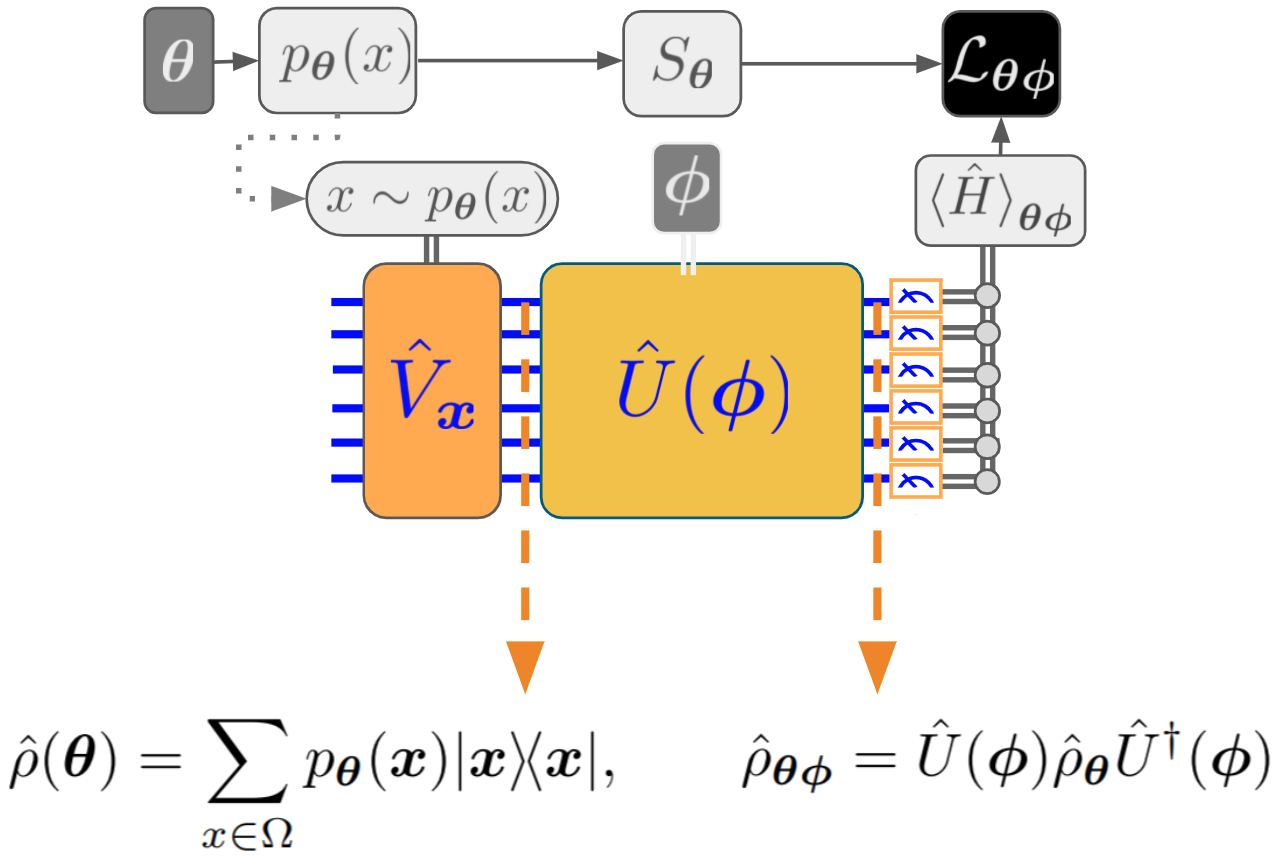

In the case of our example, we take the expectation of the state against $H=Y$, which is

$$
\text{tr}[\rho_{\theta\phi}Y] = \text{tr}\left[\frac{1}{e^{-\theta} + e^{\theta}}
\begin{bmatrix}
    e^{-\theta}\cos^2\frac{\phi}{2} + e^{\theta}\sin^2\frac{\phi}{2} & \frac{1}{2}\left(ie^{-\theta}-ie^{\theta}\right)\sin\phi \\
    \frac{1}{2}\left(ie^{\theta}-ie^{-\theta}\right)\sin\phi & e^{\theta}\cos^2\frac{\phi}{2} + e^{-\theta}\sin^2\frac{\phi}{2}
\end{bmatrix}\begin{bmatrix} 0 & -i \\ i & 0 \end{bmatrix}\right]
= \text{tr}\left[\frac{1}{e^{-\theta} + e^{\theta}}
\begin{bmatrix}
    \frac{1}{2}\left(-e^{-\theta}+e^{\theta}\right)\sin\phi & - \\ - & \frac{1}{2}\left(e^{\theta} -e^{-\theta}\right)\sin\phi
\end{bmatrix}\right]
= \frac{-e^{-\theta} + e^{\theta}}{e^{-\theta} + e^{\theta}}\sin\phi = \tanh\theta\sin\phi
$$

The entropy of the state is

$$
S(\rho_{\theta\phi}) = S(p_{\theta}) = -\frac{e^{-\theta}}{e^{-\theta} + e^{\theta}}\log\left(\frac{e^{-\theta}}{e^{-\theta} + e^{\theta}}\right)-\frac{e^{\theta}}{e^{-\theta} + e^{\theta}}\log\left(\frac{e^{\theta}}{e^{-\theta} + e^{\theta}}\right)
\\= -\frac{-\theta e^{-\theta} -e^{-\theta} \log\left(e^{-\theta} + e^{\theta}\right)}{e^{-\theta} + e^{\theta}}-\frac{\theta e^{\theta} - e^{\theta}\log\left(e^{-\theta} + e^{\theta}\right)}{e^{-\theta} + e^{\theta}}
\\= \frac{\theta e^{-\theta} + e^{-\theta} \log\left(e^{-\theta} + e^{\theta}\right)-\theta e^{\theta} + e^{\theta}\log\left(e^{-\theta} + e^{\theta}\right)}{e^{-\theta} + e^{\theta}}
\\= \frac{\theta \left(e^{-\theta} -e^{\theta}\right) + (e^\theta + e^{-\theta} )\log\left(e^{-\theta} + e^{\theta}\right)}{e^{-\theta} + e^{\theta}}
\\= -\theta\tanh\theta + \log\left(2\cosh\theta\right)
$$

Thus the VQT loss at inverse temperature $\beta$ with $H = Y$ is

$$
L_\text{vqt}(\theta, \phi) = \beta \text{tr}[\rho_{\theta\phi}Y] - S(\rho_{\theta\phi}) = \beta\tanh\theta\sin\phi +\theta\tanh\theta - \log\left(2\cosh\theta\right)
$$

In code we first need to provide some details for the vqt class, after which we can simply initialize it

In [6]:
# VQT arguments
test_num_samples = tf.constant(1e7)
test_h = tfq.convert_to_tensor(
    [cirq.PauliSum.from_pauli_strings(cirq.Y(q) for q in qubits)]) # choosing the target Hamiltonian
test_beta = tf.random.uniform([], minval=0.01, maxval=100.0, seed=seed)

with tf.GradientTape() as tape:
    loss_value = vqt_func(test_qhbm, test_num_samples, test_h, test_beta) # initializing the vqt model

### Calculate the gradient of the loss

In order to optimize, we make use of the gradient of the loss w.r.t. the parameters. The derivative of the loss with respect to $\theta$ is

$$
\frac{\partial L_\text{vqt}(\theta, \phi)}{\partial \theta} = \beta\left(1-\left(\tanh\theta\right)^2\right)\sin\phi +\tanh\theta + \theta \left(1-\left(\tanh\theta\right)^2\right) -\tanh\theta
\\ = \beta\left(1-\left(\tanh\theta\right)^2\right)\sin\phi + \theta \left(1-\left(\tanh\theta\right)^2\right)
\\ = \left(1-\left(\tanh\theta\right)^2\right)\left(\beta\sin\phi + \theta \right)
$$

The derivative of the loss with respect to $\phi$ is

$$
\frac{\partial L_\text{vqt}(\theta, \phi)}{\partial \phi} = \beta\tanh\theta\cos\phi
$$

In code, this can be calculated using a single line

In [7]:
grads = tape.gradient(loss_value, test_qhbm.trainable_variables)

###  Update parameter values

Now that we have defined all our functions, we can build an iterative loop to optimize our parameters. Here, we make use of the Adam optimizer, as well as the loss and gradient methods previously discussed

Epoch 0 finished
Epoch 50 finished
Epoch 100 finished
Epoch 150 finished
Epoch 200 finished
Epoch 250 finished
Epoch 300 finished
Epoch 350 finished
Epoch 400 finished
Epoch 450 finished


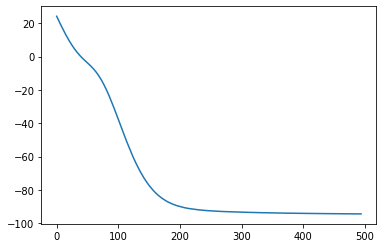

In [10]:
import matplotlib.pyplot as plt
#print("param values before optimization", test_qhbm.trainable_variables)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
loss_history = []

@tf.function # make it so that this is compiled
def train_step(epoch):
    with tf.GradientTape() as tape:
        loss_value = vqt_func(test_qhbm, test_num_samples, test_h, test_beta)
    grads = tape.gradient(loss_value, test_qhbm.trainable_variables)
    optimizer.apply_gradients(zip(grads, test_qhbm.trainable_variables))
    return loss_value

def train(epochs):
    for epoch in tf.range(epochs):
      loss_value = train_step(epoch)
      loss_history.append(loss_value.numpy().mean())
      if epoch %50 == 0:
        print ('Epoch {} finished'.format(epoch))

# call the above function    
train(epochs = 500)

#print("param values before optimization", test_qhbm.trainable_variables)

plt.plot(loss_history)

# TODO check that it converges to the - of the log(partition_beta)

### The solution

We can now generate samples of $\rho_{\sigma\phi}$ as a proxy for $\sigma_\beta$, the configuration at the thermal state. 


# Appendix

## A. Bernoulli distribution

General Bernoulli equation: \\
$$p(x) = \alpha^x (1-\alpha)^{1-x}$$
Working towards the natural form:
\begin{align}
p(x) &= e^{x \log(\alpha)+\log(1-\alpha)^{1-x}} \\
&= e^{x \log\left(\frac{\alpha}{1-\alpha}\right)+\log(1-\alpha)} \\
&= e^{2\theta x-\log(1+e^{2\theta})} \\
\text{Wi}&\text{th } \theta = \frac{1}{2}\log \left( \frac{\alpha}{1-\alpha}\right) 
\end{align}

Plugging this in the definition of $\rho_\theta$:
\begin{align}
\rho_{\theta} &\equiv \sum_{x} p(x)|x\rangle\langle x| \\
&= p(0) |0\rangle\langle 0| + p(1) |1\rangle\langle 1| \\
&= e^{0-\log(1+e^{2\theta})} \begin{bmatrix} 1 & 0 \\ 0 & 0 \end{bmatrix} 
+ e^{\gamma-\log(1+e^{2\theta})} \begin{bmatrix} 0 & 0 \\ 0 & 1 \end{bmatrix} \\
&= \frac{1}{1+e^{2\theta}} \begin{bmatrix} 1 & 0 \\ 0 & 0 \end{bmatrix}
+ \frac{e^{{2\theta}}}{1+e^{2\theta}} \begin{bmatrix} 0 & 0 \\ 0 & 1 \end{bmatrix} \\
&= \frac{1}{1+e^2\theta} \begin{bmatrix} 1 & 0 \\ 0 & e^{2\theta} \end{bmatrix} \end{align}

Now to write it in the form of a spin $\frac{1}{2}$ particle:
\begin{align}
&= \frac{e^{-\theta}}{e^{-\theta}} * \frac{1}{1+e^2\theta} \begin{bmatrix} 1 & 0 \\ 0 & e^{2\theta} \end{bmatrix} \\
&= \frac{1}{e^{-\theta} + e^{\theta}}\begin{bmatrix}
    e^{-\theta} & 0 \\
    0 & e^{\theta}
\end{bmatrix}.
\end{align}